# First data exploration

### Extracting and cleaning plot summaries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from transformers import pipeline
from scipy.special import softmax


import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

#Setting pandas display options
pd.set_option("max_colwidth", None)


from sentence_transformers import SentenceTransformer, util


#Src folder path
src_folder = 'src/data/'

C:\Users\Mathieu\anaconda3\envs\ada\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mathieu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Mathieu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
df_plot_summaries = pd.read_csv(src_folder + 'plot_summaries.txt', sep='\t', header=None,  names=['id', 'summary'])
df_plot_summaries.sample(2)

,id,summary
7256,23713094,"Easygoing cowboy Dempsey Rae and his impressionable young friend Jeff Jimson ([[William Campbell wander into town and are hired to work for an absentee rancher named Reed Bowman. When Bowman finally shows up, Dempsey is surprised to find that he has been working for a very attractive woman , one who has very ambitious plans. These lead to conflict with her neighbors."
6565,30588178,"When the older brother he idolizes is run off the road by a ruthless drug dealer during a nighttime street race known as Sepulveda Suicide, Rick Merchant channels his grief into getting revenge behind the wheel. But to win, he'll need to modify his trusty 1988 Mazda RX-7/Nissan 240sx -- with help from a mechanic Kelly -- to get the maximum performance out of his machinery."


Some cleaning is necessary for the plot summaries. There appears to be in the data:

1) {{annotation}}
2) links (references to wikipedia)
3) <> html delimiters
4) ... further inspection needed

That need to be removed


In [3]:
def clean_plot(txt):

    #Remove URLs
    txt = re.sub(r"http\S+|www\.\S+", '', txt)

    #Remove HTML tags
    txt = re.sub(r'<.*?>', '', txt)

    #Remove {{annotations}}
    txt = re.sub(r'\{\{.*?\}\}', '', txt)

    #Remove the ([[ annotation that is never closed
    txt = re.sub(r'\(\[\[', '', txt)

    #Remove the synopsis from context
    txt = re.sub(r'Synopsis from', '', txt)

    #Remove <ref...}} tags
    txt = re.sub(r'<ref[^}]*}}', '', txt)

    return txt

In [4]:
df_test_clean = df_plot_summaries.copy()
df_test_clean["summary"] = df_plot_summaries['summary'].apply(clean_plot)
df_test_clean.sample(2)

,id,summary
17020,4469806,"Phil is a successful advertising executive and Maisie is his young and hedonistic wife, but their lives are thrown into turmoil when Phil inherits his great-great grandfather's secret diaries. He becomes obsessed with research into solid geometry contained in the diaries and is fascinated by the theory of ""a plane without a surface."" His pursuit of this mythical geometric concept tears his marriage apart. The film is interspersed with flashbacks showing Phil's great-great grandfather discovering the same mysteries of the supernatural side of geometry as Phil is uncovering by reading the diaries. Eventually Phil follows the instructions buried in the diaries and begins carefully folding a large sheet of paper in on itself like a lotus flower, then the folded paper emits a bright light, folds over itself and disappears. On seeing this, he dedicated his life to understanding more about the diaries and his great-great grandfather's mysterious disappearance. He goes on to become obsessed with this transformation and the discussion in the book which links it to 'sexual intercourse positions' of which the diary claims there are only 17. After a love-making session with his wife, he proceeds to place another of the paper lotus flowers in the center of her curled body. As she curls into a foetal position unknowingly around the paper flower, she somehow completes the flower folding as had previously been achieved with just the paper. She spins around the paper flower several times and disappears, emitting tones of shock and fear. The film ends with Phil alone in bed."
8173,26065372,"Changayya is a wealthy Sowkar whose son Satyam is studying in the city. His neighbour is Ramayya . Changayya is affectionate towards his daughter Subbulu and wants to make her his daughter-in-law. Satyam also likes this idea. But due to some conflict in the village courtesy Bangarayya, Ramayya provides the police witness against Changayya citing his hand present in the messy affair. The two families are thereafter estranged. They start off with petty fights, getting worse every day culminating with Satyam and Ramayya's son Narayana ending up in jail after being framed. The local goonda Sunnapu Rangadu plans to rob Changayya's place, but his plans are spoiled by Subbulu and Ramayya. Both the families end their differences, and become friendly once again. At the end, Satyam and Subbulu marry and live happily."


    histogram of the length of the summary

### check if we need to webscrap some summary from internet (if the summary is too short)

In [5]:
df_length_summary = df_test_clean['summary'].copy(deep=True)
df_length_summary = df_length_summary.apply(len) 


Text(0.5, 1.0, 'Distribution of the length of the summary')

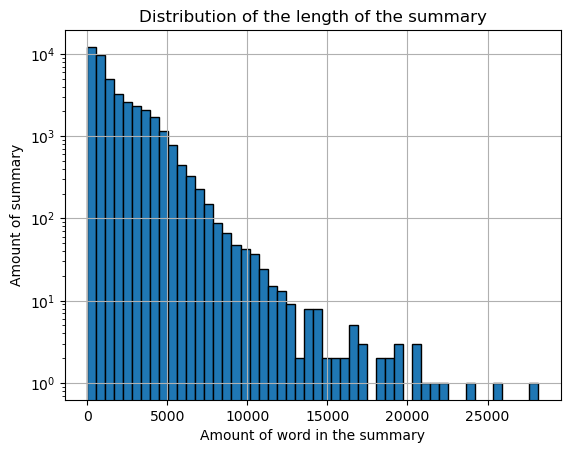

In [25]:
df_length_summary.hist(bins=50, edgecolor='black')
plt.yscale('log')
plt.xlabel('Amount of word in the summary')
plt.ylabel('Amount of summary')
plt.title('Distribution of the length of the summary')

Text(0.5, 1.0, 'Distribution of the summary that have length <= 1000')

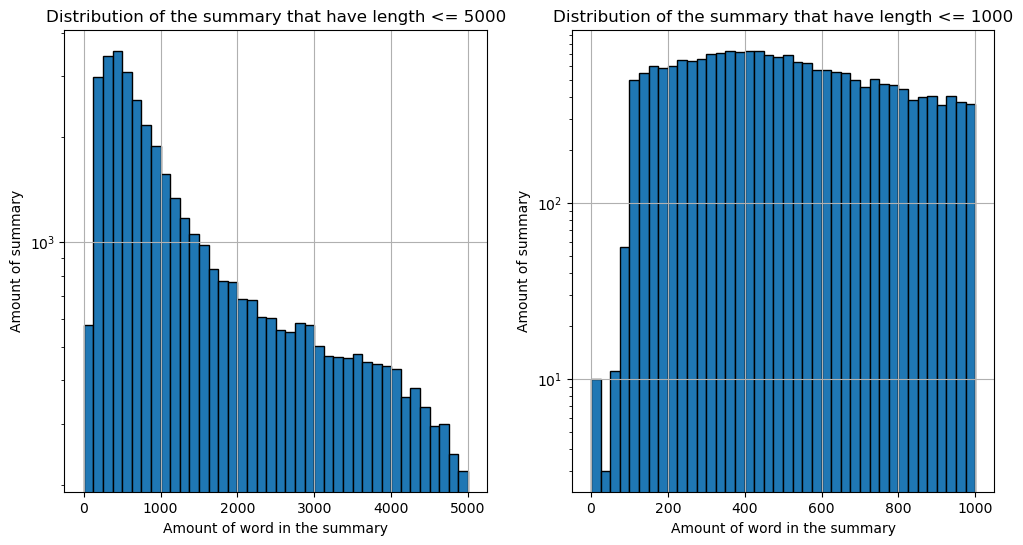

In [27]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.ravel()

df_length_summary_below_5000 = df_length_summary[df_length_summary <= 5000]
df_length_summary_below_5000.hist(bins=40, edgecolor='black', ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('Amount of word in the summary')
axes[0].set_ylabel('Amount of summary')
axes[0].set_title('Distribution of the summary that have length <= 5000')


df_length_summary_below_1000 = df_length_summary[df_length_summary <= 1000]
df_length_summary_below_1000.hist(bins=40, edgecolor='black', ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('Amount of word in the summary')
axes[1].set_ylabel('Amount of summary')
axes[1].set_title('Distribution of the summary that have length <= 1000')

#### Sentiment analysis test

I see two possibilities: making classical sentiment analysis using twitter-roberta-base-sentiment trained on tweets or using distilbert-base-uncased-emotions for emotions

In [8]:
#First possibility: sentence by sentence sentiment classification

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)



dict_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}
for t in df_test_clean['summary'].sample(1):
    for sentence in nltk.sent_tokenize(t):
        print(sentence)
        t_encoded = tokenizer(sentence, return_tensors='pt')
        t_output = model(**t_encoded)
        t_scores = softmax(t_output.logits.detach().numpy(), axis=1)
        t_predicted = np.argmax(t_scores)
        print(dict_labels[t_predicted], t_scores[0][t_predicted])
    

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In the early 1950s, Kalique, a port in North Africa, a man  is escorted through an angry, clamouring crowd by a platoon of soldiers.
negative 0.5098169
They enter a fort and it is clear that he is to be executed.
negative 0.7032658
The commander  orders the men to line up in two rows and gives the order to fire.
neutral 0.9217663
As the shots ring out, the scene changes to a ferry ship, the "Golden Fleece" in the docks as the passengers embark for the two days' journey to Gibralter.
neutral 0.8877307
Amongst the crew, there is much dismay, and the chief officer, Carlos Ricco takes to his cabin with the clear intention of getting drunk.
negative 0.75938505
He is interrupted by an elderly gentleman, Lawrence St. James  who had come to speak his nephew, Captain Henry St. James on an unspecified, but urgent, matter.
neutral 0.8577401
He is profoundly shocked to learn that the grief he had encountered on the ship is due to the death of the man he had traveled from England to see.
negative 0

In [9]:
# Second possibility: sentence to sentence emotion classification

#the emotions are anger, fear, joy, love, sadness, surprise and neutral

classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

for t in df_test_clean['summary'].sample(1):
    for sentence in nltk.sent_tokenize(t):
        print(sentence)
        out = classifier(sentence)[0]
        best_emotion_dict = max(out, key=lambda x: x['score'])
        best_label = best_emotion_dict['label']
        best_score = best_emotion_dict['score']
        print(best_label, best_score)    

C:\Users\Mathieu\anaconda3\envs\ada\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Developer Tsang Siu-Chi  and his agent  have bought two of a group of four properties.
joy 0.838080883026123
Rival developer, Boss Hung  has secured the other two properties.
neutral 0.8351715803146362
Both aim to buy all four so they can knock them down and build hotels.
neutral 0.8861842751502991
The agent learns that billionaire Kuwaiti Prince Allabarba  is due to arrive in Hong Kong and advises Tsang that they could dupe him in order to gain a billion dollar contract.
neutral 0.7321462631225586
The prince's father has recently died and the prince bitterly regrets that he wasn't a good son.
sadness 0.9764199256896973
The agent tells Tsang that he should make a show of the positive relationship he has with his father, to impress the prince.
neutral 0.7223976850509644
Unfortunately, Tsang has not seen his father  for 10 years.
sadness 0.9425522685050964
Along with his wife  and his sycophantic assistant , Tsang heads off to bring his father back.
neutral 0.83636474609375
When they mee

In [10]:
#keep small summary to test the segmentation
df_test_clean_with_length = df_test_clean.copy(deep=True)
df_test_clean_with_length['length'] = df_test_clean_with_length['summary'].apply(len) 
df_test_clean_with_length = df_test_clean_with_length[df_test_clean_with_length['length'] < 150]
df_test_clean_with_length.head(5)

,id,summary,length
39,28238240,"Mickey and the Scorpions decide to go on a big game hunt. The kids go out into the woods, only find themselves up against real wild animals .",141
55,27975390,"Reportedly, the film is about slum kids who are trained for a dance competition.Shaimak Davar in a director's avatar",116
116,33837735,"Emilio di Roccanera, The Black Corsair, seeks revenge against Governor Van Guld for the murder of his family.",109
184,27997130,Three young Russians from very different walks of life involutarily enter the military to escape their past.,108
198,9916623,"Butte Morgan plans to take over the circus my marrying Maria Wallace. She, however, is interested only in the trick rider Jack Grant.",134


In [11]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

df_summary = df_test_clean_with_length['summary']
# Exemple de résumé (ce texte serait votre résumé complet de film)
summary = """
The story begins with the protagonist arriving in a new town. He feels out of place at first, but soon makes friends. 
As the days pass, he gets entangled in local conflicts and starts to develop a romantic interest. 
This leads to a series of challenges that test his resolve. 
In the final showdown, he faces his ultimate challenge and emerges victorious, having found a new sense of belonging.
"""

# 1. Diviser le résumé en phrases
sentences = summary.split(". ")
sentences = [s.strip() for s in sentences if s]  # Supprimer les espaces et les phrases vides

# 2. Obtenir les embeddings de chaque phrase
embeddings = model.encode(sentences)

# 3. Calculer les similarités cosinus entre phrases successives
similarities = [util.pytorch_cos_sim(embeddings[i], embeddings[i+1]).item() for i in range(len(embeddings)-1)]

# 4. Identifier les points de transition basés sur un seuil de similarité
threshold = 0.5  # Par exemple, une similarité inférieure à 0.5 indique un changement de thème
segments = []
current_segment = [sentences[0]]

for i, similarity in enumerate(similarities):
    if similarity < threshold:  # Si la similarité est faible, cela peut indiquer une transition
        segments.append(" ".join(current_segment))  # Ajouter le segment actuel à la liste
        current_segment = []  # Réinitialiser pour un nouveau segment
    current_segment.append(sentences[i + 1])

segments.append(" ".join(current_segment))  # Ajouter le dernier segment

# 5. Afficher les segments
for idx, segment in enumerate(segments):
    print(f"Segment {idx+1}:\n{segment}\n")

C:\Users\Mathieu\anaconda3\envs\ada\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Mathieu\.cache\huggingface\hub\models--sentence-transformers--paraphrase-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Segment 1:
The story begins with the protagonist arriving in a new town

Segment 2:
He feels out of place at first, but soon makes friends As the days pass, he gets entangled in local conflicts and starts to develop a romantic interest

Segment 3:
This leads to a series of challenges that test his resolve

Segment 4:
In the final showdown, he faces his ultimate challenge and emerges victorious, having found a new sense of belonging.



In [12]:
# Second possibility: sentence to sentence emotion classification

#the emotions are anger, fear, joy, love, sadness, surprise and neutral

classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

for t in df_test_clean['summary'].sample(1):
    for sentence in nltk.sent_tokenize(t):
        print(sentence)
        out = classifier(sentence)[0]
        best_emotion_dict = max(out, key=lambda x: x['score'])
        best_label = best_emotion_dict['label']
        best_score = best_emotion_dict['score']
        print(best_label, best_score)    

C:\Users\Mathieu\anaconda3\envs\ada\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In 1912, a teenage boy named Albert Narracott  from Devon, England, witnesses the birth of a Bay Thoroughbred foal and subsequently watches with admiration the growth of the young horse, galloping through the fields at his mother's side.
disgust 0.5900802612304688
Much to the dismay of his mother Rose , his father Ted  buys the colt at auction, despite a friend pointing out a more suitable plough horse for his farm.
sadness 0.7070714235305786
Desiring to spite his landlord Mr Lyons , and retain his pride, Ted bids higher and higher for the colt.
anger 0.8764840364456177
The high cost of the horse (30 [[Guinea  means he is unable to pay rent to Lyons, who threatens to take possession of the farm if the money is not paid by autumn.
fear 0.8351001739501953
Ted promises to meet the deadline, suggesting he could plough and plant a lower, rock-filled field with turnips.
neutral 0.837209165096283
Albert names the horse Joey and devotes much time to training him.
neutral 0.94881671667099
Alber

sadness 0.47441136837005615
When he learns that only officers' horses will be shipped home, he accepts funds from his fellow soldiers to purchase Joey at a scheduled highest-bidder auction, but finds himself losing a bidding war with a French butcher, reaching 30 pounds.
disgust 0.5976260900497437
Then a bid of 100 pounds is entered.
neutral 0.9036930799484253
The bidder is an older gentleman, Emilie's grandfather, who informs the butcher that if he is bid against, he will sell his coat and bid to 110 -- and should he be bid against again, he will sell his farm and bid to 1000.
neutral 0.7153807878494263
No other bid is placed, and the grandfather takes ownership of Joey, planning to return with him to his farm.
sadness 0.4292505383491516
He tells Albert that Emilie has died, and after hearing about the miracle horse, he has walked three days to get Joey back, for the sake of his beloved granddaughter's memory.
sadness 0.9285565614700317
Albert pleads for the horse with Emilie's grandf

In [118]:
#try to segment the text in a more clever way I guess?
from sentence_transformers import SentenceTransformer, util
nltk.download('punkt')  # Télécharge le tokenizer nécessaire pour les phrases

# Initialisation du modèle de classification d'émotions
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

# Initialisation du modèle de similarité de phrases
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Exemple de résumé (ou utilisez df_test_clean_with_length['summary'] pour appliquer à tout le dataset)
summary = """
The story begins with the protagonist arriving in a new town. He feels out of place at first, but soon makes friends. 
As the days pass, he gets entangled in local conflicts and starts to develop a romantic interest. 
This leads to a series of challenges that test his resolve. 
In the final showdown, he faces his ultimate challenge and emerges victorious, having found a new sense of belonging.
"""
summary = df_summary_box_office.iloc[3]['summary']

# 1. Diviser le résumé en phrases
sentences = nltk.sent_tokenize(summary)  # Utiliser nltk pour la tokenisation des phrases
sentences = [s.strip() for s in sentences if s]  # Supprimer les espaces et les phrases vides

# 2. Obtenir les embeddings de chaque phrase
embeddings = model.encode(sentences)

# 3. Calculer les similarités cosinus entre phrases successives
similarities = [util.pytorch_cos_sim(embeddings[i], embeddings[i+1]).item() for i in range(len(embeddings)-1)]

# 4. Identifier les points de transition basés sur un seuil de similarité
threshold = 0.5  # Par exemple, une similarité inférieure à 0.5 indique un changement de thème
segments = []
current_segment = [sentences[0]]

for i, similarity in enumerate(similarities):
    if similarity < threshold:  # Si la similarité est faible, cela peut indiquer une transition
        segments.append(" ".join(current_segment))  # Ajouter le segment actuel à la liste
        current_segment = []  # Réinitialiser pour un nouveau segment
    current_segment.append(sentences[i + 1])

segments.append(" ".join(current_segment))  # Ajouter le dernier segment

# 5. Analyser les émotions de chaque segment et afficher les résultats
best_emotions = []
emotionsS = []
for idx, segment in enumerate(segments):
    print(f"Segment {idx+1}:\n{segment}\n")
    
    # Classifier les émotions pour chaque segment
    emotions = classifier(segment)[0]
    emotionsS.append(emotions)
    best_emotion = max(emotions, key=lambda x: x['score'])  # Sélectionner l'émotion avec le score le plus élevé
    best_emotions.append(best_emotion)
    # Afficher l'émotion dominante pour le segment
    print(f"Emotion dominante pour le Segment {idx+1}: {best_emotion['label']} : {best_emotion['score']:.2f}\n")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mathieu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Mathieu\anaconda3\envs\ada\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Segment 1:
Debbie's favorite band is Dream Street, and her favorite member is Chris Trousdale.

Emotion dominante pour le Segment 1: joy : 0.89

Segment 2:
When Chris gets a fever while travelling on the Dream Street tour, in a haze, he strays away and ends up in Debbie's bed, much to the shock of his "Biggest Fan," who thinks she's in heaven.

Emotion dominante pour le Segment 2: surprise : 0.87

Segment 3:
Debbie proposes that Chris stay with her and he agrees.

Emotion dominante pour le Segment 3: neutral : 0.78

Segment 4:
So, over the week they spend time together and she secretly hides him so he can escape the pressures of being a pop star for a little while.

Emotion dominante pour le Segment 4: neutral : 0.92

Segment 5:
Chris even attends high school with Debbie, while disguised as a nerd.

Emotion dominante pour le Segment 5: disgust : 0.61

Segment 6:
Meanwhile, the band's managers are going crazy at the loss of the star, thinking he has been kidnapped.

Emotion dominante po

In [119]:
emotions = np.array([best_em['label'] for best_em in best_emotions])
scores = np.array([best_em['score'] for best_em in best_emotions])


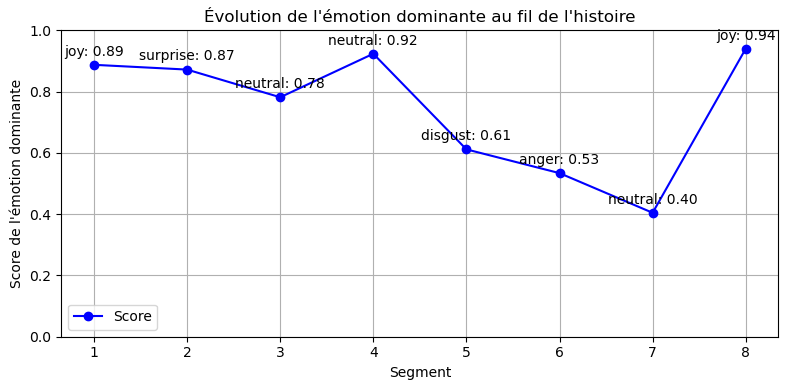

In [120]:

# Créer une liste de numéros de segment pour l'axe x
x = list(range(1, len(segments) + 1))

# Tracer les scores pour chaque segment
plt.figure(figsize=(8, 4))
plt.plot(x, scores, marker='o', linestyle='-', color='b', label='Score')

# Ajouter des annotations pour chaque point (émotion dominante)
for i, (emotion, score) in enumerate(zip(emotions, scores), start=1):
    plt.text(i, score + 0.02, f'{emotion}: {score:.2f}', ha='center', va='bottom')
# Configurer le graphique
plt.ylim(0, 1)
plt.xlabel('Segment')
plt.ylabel('Score de l\'émotion dominante')
plt.title('Évolution de l\'émotion dominante au fil de l\'histoire')
plt.xticks(x)  # Afficher les numéros de segment sur l'axe x
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()


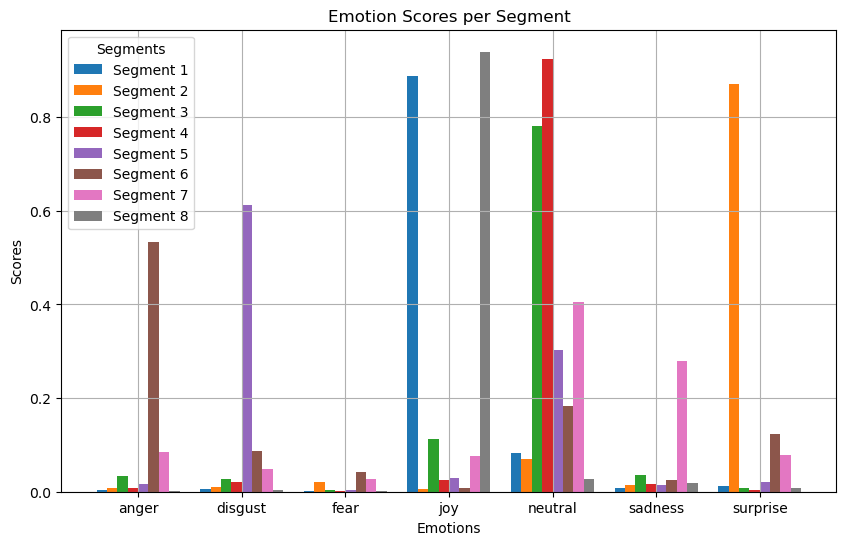

In [121]:

# Extract the list of emotions from the first segment
emotions = [entry['label'] for entry in emotionsS[0]]

# Extract scores for each emotion in each segment
scores = []
for segment in emotionsS:
    segment_scores = [entry['score'] for entry in segment]
    scores.append(segment_scores)

fig, ax = plt.subplots(figsize=(10, 6))

num_segments = len(emotionsS)
bar_width = 0.1

indices = np.arange(len(emotions))

for i in range(num_segments):
    ax.bar(indices + i * bar_width, scores[i], width=bar_width, label=f'Segment {i+1}')

# Set x-ticks in the middle of each group of bars
ax.set_xticks(indices + bar_width * (num_segments - 1) / 2)
ax.set_xticklabels(emotions)

# Add labels and title
ax.set_xlabel('Emotions')
ax.set_ylabel('Scores')
ax.set_title('Emotion Scores per Segment')
ax.legend(title='Segments')
plt.grid(True)

plt.show()


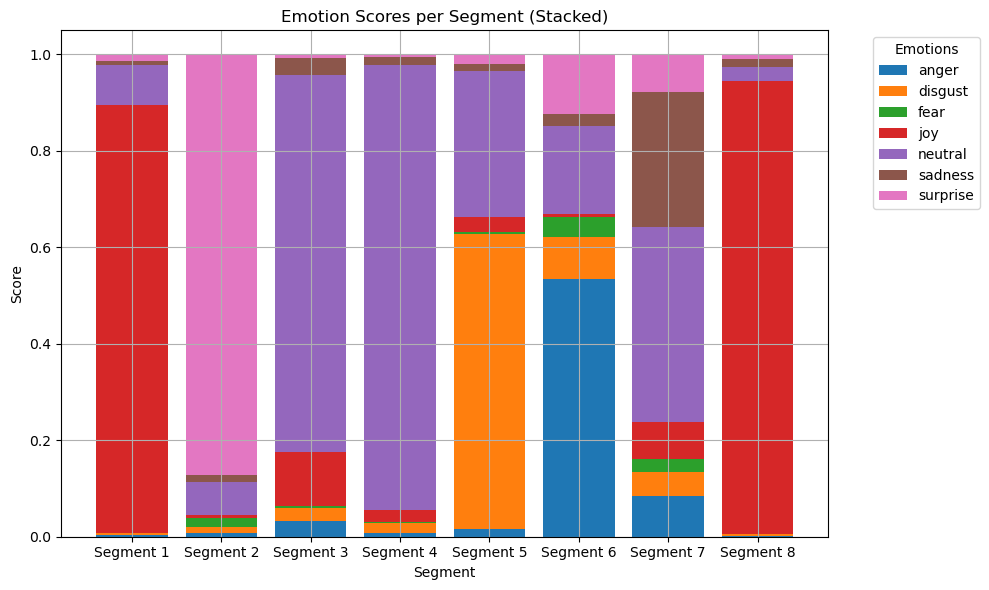

In [122]:
emotions = [entry['label'] for entry in emotionsS[0]]
scores_by_emotion = {emotion: [] for emotion in emotions}

for segment in emotionsS:
    for entry in segment:
        scores_by_emotion[entry['label']].append(entry['score'])

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(1, len(emotionsS) + 1)  # x positions for the bars (1, 2, 3, ...)

bottom = np.zeros(len(emotionsS))  # Initialize the bottom for stacking
for emotion in emotions:
    scores = scores_by_emotion[emotion]
    bars = ax.bar(x, scores, bottom=bottom, label=emotion)
    bottom += scores

ax.set_xlabel('Segment')
ax.set_ylabel('Score')
ax.set_title('Emotion Scores per Segment (Stacked)')
ax.set_xticks(x)
ax.set_xticklabels([f'Segment {i}' for i in x])
ax.legend(title='Emotions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()

plt.show()


In [123]:
df_metadata = pd.read_csv(src_folder + 'movie.metadata.tsv', sep='\t', header=None,
                                    names=['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name', 
                                            'Movie_release_date', 'Movie_box_office_revenue', 'Movie_runtime',
                                            'Movie_languages_(Freebase ID:name tuples)', 'Movie_countries_(Freebase ID:name tuples)',
                                           'Movie_genres_(Freebase ID:name tuples)'])

In [117]:
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Define a function to process each summary into segments and get emotion scores
def process_summary(summary, threshold=0.5):
    # Split the summary into sentences
    sentences = nltk.sent_tokenize(summary)
    sentences = [s.strip() for s in sentences if s]  # Remove empty sentences
    
    # Get embeddings and calculate similarities
    embeddings = model.encode(sentences)
    similarities = [util.pytorch_cos_sim(embeddings[i], embeddings[i+1]).item() for i in range(len(embeddings)-1)]
    
    # Split into segments based on similarity threshold
    segments = []
    current_segment = [sentences[0]]
    
    for i, similarity in enumerate(similarities):
        if similarity < threshold:
            segments.append(" ".join(current_segment))
            current_segment = []
        current_segment.append(sentences[i + 1])
    
    segments.append(" ".join(current_segment))  # Add the last segment

    # Get emotion scores for each segment
    segment_data = []
    for segment in segments:
        emotion_scores = {emotion['label']: emotion['score'] for emotion in classifier(segment)[0]}
        segment_data.append(emotion_scores)
    
    # Create DataFrame for this summary
    df_summary = pd.DataFrame(segment_data)
    return df_summary

# Assuming you have a main DataFrame df_summaries with a 'summary' column
# Process each summary and store the result as a dictionary of DataFrames
summary_dfs = {}  # To store DataFrames for each summary
df_summaries = df_summary_box_office.copy(deep=True).iloc[:5]
for idx, (_, row) in tqdm(enumerate(df_summaries.iterrows())):
    summary_text = row['summary']
    df_summary = process_summary(summary_text)
    df_summary['box_office'] = row['Movie_box_office_revenue']
    summary_dfs[idx] = df_summary  # Save the DataFrame by index or summary ID

# Display an example DataFrame for the first summary
#summary_dfs = list(summary_dfs.values())

C:\Users\Mathieu\anaconda3\envs\ada\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
5it [00:03,  1.42it/s]


A partir de ça, essayer de faire une regression linéaire avec ces valeurs et le box office?

In [92]:
summary_dfs[1]

,anger,disgust,fear,joy,neutral,sadness,surprise,box_office
0,0.015909,0.360593,0.074287,0.083013,0.441330,0.017648,0.007220,3600000.0
1,0.046567,0.028003,0.014420,0.002598,0.019672,0.755141,0.133598,3600000.0
2,0.008265,0.003391,0.002375,0.714402,0.241563,0.014584,0.015420,3600000.0
3,0.009519,0.033427,0.029517,0.049199,0.344299,0.439187,0.094852,3600000.0
4,0.108386,0.795926,0.079717,0.001256,0.007907,0.005229,0.001579,3600000.0
5,0.075555,0.013941,0.883170,0.001055,0.017044,0.006677,0.002558,3600000.0
6,0.041219,0.543497,0.006892,0.053258,0.256651,0.061347,0.037136,3600000.0
7,0.099680,0.836528,0.027586,0.001216,0.016841,0.017131,0.001019,3600000.0
8,0.266777,0.681277,0.006135,0.001323,0.024171,0.016495,0.003822,3600000.0
9,0.407407,0.054142,0.090100,0.010271,0.418572,0.011563,0.007944,3600000.0


In [23]:
df_summary_box_office = pd.concat([df_test_clean['summary'], df_metadata['Movie_box_office_revenue']], axis=1)
print(df_summary_box_office.shape)
df_summary_box_office.dropna(axis=0, inplace=True)
df_summary_box_office.shape

(81741, 2)


(4392, 2)

    Beaucoup de film n'ont pas de box office => bien de webscraper ça

In [124]:
df_summary_box_office.iloc[3]['summary']

'Debbie\'s favorite band is Dream Street, and her favorite member is Chris Trousdale. When Chris gets a fever while travelling on the Dream Street tour, in a haze, he strays away and ends up in Debbie\'s bed, much to the shock of his "Biggest Fan," who thinks she\'s in heaven. Debbie proposes that Chris stay with her and he agrees. So, over the week they spend time together and she secretly hides him so he can escape the pressures of being a pop star for a little while. Chris even attends high school with Debbie, while disguised as a nerd. Meanwhile, the band\'s managers are going crazy at the loss of the star, thinking he has been kidnapped. At the end of the week Debbie and Chris  go to her high school prom where two jealous popular girls figure out Chris\'s true identity and tell the police about Chris\'s whereabouts, splitting him and Debbie up. They are eventually reunited on stage at a concert, ending in a sweet, final kiss and a performance by Dream Street.'